In [1]:
from spectacle.core.spectra import Spectrum1D
from spectacle.process.lsf import LSF
from spectacle.analysis.metrics import correlate, npcorrelate, cross_correlate, autocorrelate
import matplotlib.pyplot as plt
import numpy as np
import uncertainties.unumpy as unp

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 8]

# Correlation Metric Analysis

This notebook goes through a few different correlation metrics being explored right now.

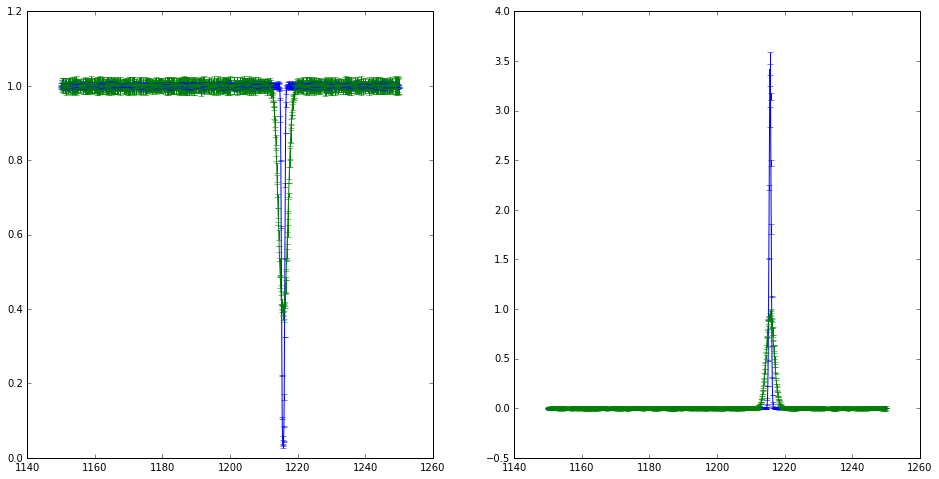

In [3]:
# Generate two spectrums to use for correlation

disp = np.arange(1150, 1250, 0.1)

spectrum1 = Spectrum1D(dispersion=disp, uncertainty=np.random.sample(1000) * 0.01)
spectrum1.add_line(lambda_0=1.21567010E+03, f_value=0.4164, v_doppler=1e7, column_density=10**14.66, name="Halpha")
spectrum1.add_noise(0.0025)
# cos_lsf = LSF(instrument='cos')
# spectrum1.add_lsf(cos_lsf)

spectrum2 = Spectrum1D(dispersion=disp, uncertainty=np.random.sample(1000) * 0.025)
spectrum2.add_line(lambda_0=1.21567010E+03, f_value=0.4164, v_doppler=4e7, column_density=10**14.7, name="Halpha")
spectrum2.add_noise(std_dev=0.001)
# cos_lsf = LSF(instrument='cos')
# spectrum2.add_lsf(cos_lsf)

# mask = (spectrum1.dispersion > 1150) & (spectrum1.dispersion < 1250)
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.errorbar(spectrum1.dispersion, spectrum1.flux, yerr=spectrum1.uncertainty)
ax1.errorbar(spectrum2.dispersion, spectrum2.flux, yerr=spectrum2.uncertainty)
ax2.errorbar(spectrum1.dispersion, spectrum1.tau, yerr=spectrum1.tau_uncertainty)
ax2.errorbar(spectrum2.dispersion, spectrum2.tau, yerr=spectrum2.tau_uncertainty)
plt.show()

## Peeples Correlation

### Full

Sum: 5.171533965711522
Tau Sum: 39048974.45315854


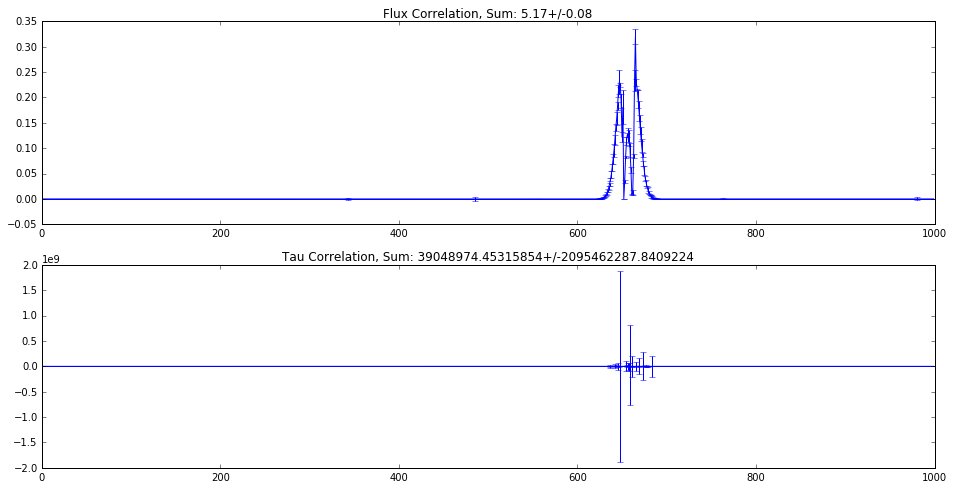

In [4]:
vals, uncerts = correlate(spectrum1, spectrum2)
tvals, tuncerts = correlate(spectrum1, spectrum2, use_tau=True)

flux_sum = unp.uarray(vals, uncerts).sum()
tau_sum = unp.uarray(tvals, tuncerts).sum()

print("Sum: {}".format(flux_sum.nominal_value, flux_sum.std_dev))
print("Tau Sum: {}".format(tau_sum.nominal_value, tau_sum.std_dev))

f, (ax1, ax2) = plt.subplots(2, 1)
ax1.errorbar(range(len(vals)), vals, yerr=uncerts)
ax1.set_title("Flux Correlation, Sum: {}".format(unp.uarray(vals, uncerts).sum()))
ax2.errorbar(range(len(tvals)), tvals, yerr=tuncerts)
ax2.set_title("Tau Correlation, Sum: {}+/-{}".format(tau_sum.nominal_value, tau_sum.std_dev))
plt.show()

### Lite

Sum: 1147+/-6
Tau Sum: (0+/-5)e+09


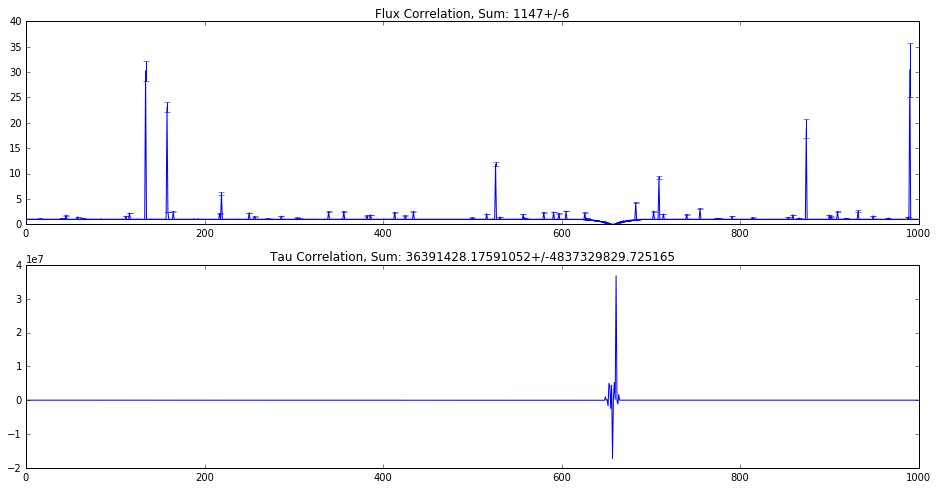

In [5]:
vals, uncerts = correlate(spectrum1, spectrum2, mode='lite')
tvals, tuncerts = correlate(spectrum1, spectrum2, mode='lite', use_tau=True)

tau_sum = unp.uarray(tvals, tuncerts).sum()

print("Sum: {}".format(unp.uarray(vals, uncerts).sum()))
print("Tau Sum: {}".format(tau_sum))

f, (ax1, ax2) = plt.subplots(2, 1)
ax1.errorbar(range(len(vals)), vals, yerr=uncerts)
ax1.set_title("Flux Correlation, Sum: {}".format(unp.uarray(vals, uncerts).sum()))
ax2.errorbar(range(len(tvals)), tvals)#, yerr=tuncerts)
ax2.set_title("Tau Correlation, Sum: {}+/-{}".format(tau_sum.nominal_value, tau_sum.std_dev))
plt.show()

## Numpy Correlate

### `Valid` mode
Mode ‘valid’ returns output of length max(M, N) - min(M, N) + 1. The convolution product is only given for points where the signals overlap completely. Values outside the signal boundary have no effect.

In [6]:
vals, uncerts = npcorrelate(spectrum1, spectrum2)
tvals, tuncerts = npcorrelate(spectrum1, spectrum2, use_tau=True)

print(unp.uarray(vals, uncerts))
print(unp.uarray(tvals, tuncerts))

[975.8402355625689+/-0.481821734322223]
[22.951661247513293+/-0.3648983428577495]


### `Same` mode
Mode ‘same’ returns output of length max(M, N). Boundary effects are still visible.

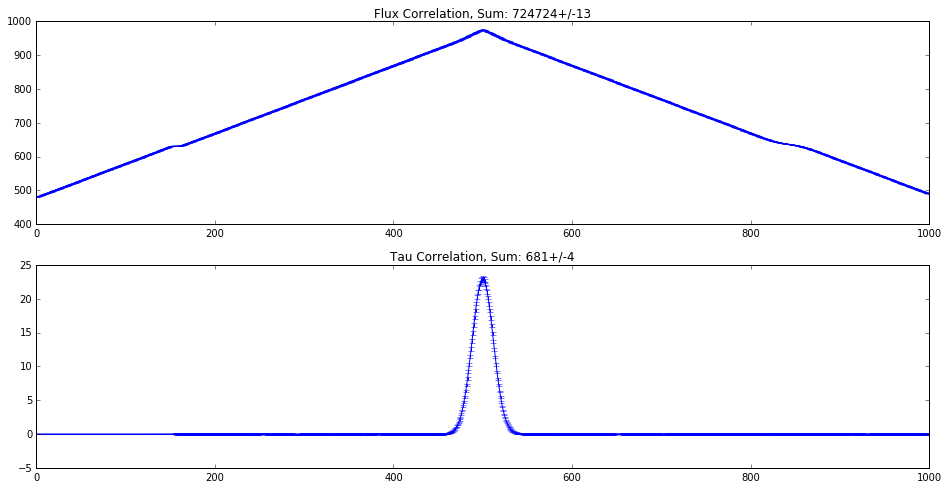

In [7]:
vals, uncerts = npcorrelate(spectrum1, spectrum2, mode='same')
tvals, tuncerts = npcorrelate(spectrum1, spectrum2, mode='same', use_tau=True)

f, (ax1, ax2) = plt.subplots(2, 1)
ax1.errorbar(range(len(vals)), vals, yerr=uncerts)
ax1.set_title("Flux Correlation, Sum: {}".format(unp.uarray(vals, uncerts).sum()))
ax2.errorbar(range(len(tvals)), tvals, yerr=tuncerts)
ax2.set_title("Tau Correlation, Sum: {}".format(unp.uarray(tvals, tuncerts).sum()))
plt.show()

### `Full` mode
By default, mode is ‘full’. This returns the convolution at each point of overlap, with an output shape of (N+M-1,). At the end-points of the convolution, the signals do not overlap completely, and boundary effects may be seen.

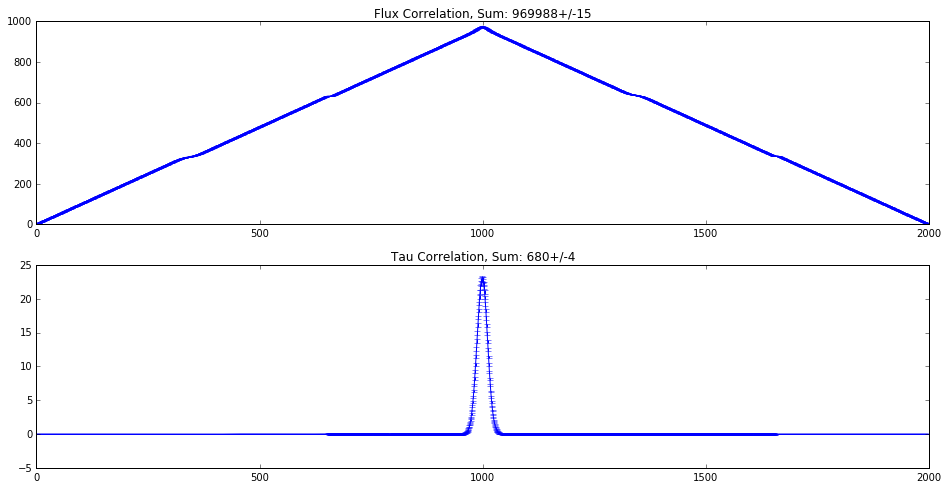

In [8]:
vals, uncerts = npcorrelate(spectrum1, spectrum2, mode='full')
tvals, tuncerts = npcorrelate(spectrum1, spectrum2, mode='full', use_tau=True)

f, (ax1, ax2) = plt.subplots(2, 1)
ax1.errorbar(range(len(vals)), vals, yerr=uncerts)
ax1.set_title("Flux Correlation, Sum: {}".format(unp.uarray(vals, uncerts).sum()))
ax2.errorbar(range(len(tvals)), tvals, yerr=tuncerts)
ax2.set_title("Tau Correlation, Sum: {}".format(unp.uarray(tvals, tuncerts).sum()))
plt.show()

## Peeples Autocorrelate

In [9]:
res1 = autocorrelate(spectrum1)
res2 = autocorrelate(spectrum2)
tres1 = autocorrelate(spectrum1, use_tau=True)
tres2 = autocorrelate(spectrum2, use_tau=True)

print("Spectrum1: {}".format(unp.uarray(*res1)))
print("Spectrum2: {}".format(unp.uarray(*res2)))

print("Tau Spectrum1: {}".format(unp.uarray(*tres1)))
print("Tau Spectrum2: {}".format(unp.uarray(*tres2)))

Spectrum1: 1.007834+/-0.000023
Spectrum2: 1.00895+/-0.00009
Tau Spectrum1: 95.6+/-1.5
Tau Spectrum2: 24.7+/-0.8
